# <span style='color:blue'> LAB 3: </span>
# <span style='color:blue'> FULLY CONNECTED DEEP NETWORKS </span>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import numpy as np

# <span style='color:red'> Part 2: Additional Data Prep Methods ----------------------------------------------------------</span>

### 2.1 - One-hot Encoding

In [2]:
# Each integer corresponding to a label

labels = torch.tensor([0,1,2]) 
print(labels)

tensor([0, 1, 2])


In [3]:
# Using torch.nn.functional.one_hot() to convert the integer labels to one-hot encoding

labels_one_hot = torch.nn.functional.one_hot(labels) 
print(labels_one_hot)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])


# <span style='color:red'> Part 5: Training FCN (Iris Classification example) -------------------------------------------</span>

### Prepare Data

In [2]:
# Import necessary functions from scikit-learn library
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# iris dataset is available from scikit-learn package
iris = load_iris()

# Load the X (features) and y (targets) for training
X = iris['data']
y = iris['target']

# Scale the input dataset X with standard scaling using scikit-learn
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset with training (80%) and testing (20%) using train_test_split from scikit_learn
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

# We will additionally split the training data into training and validation
# The final split ratios are training: 60%, validation: 20% and testing 20%
X_validation = X_train[:int(len(X_test))]
y_validation = y_train[:int(len(X_test))]

X_train = X_train[int(len(X_test)):]
y_train = y_train[int(len(X_test)):]

### Define Model

In [3]:
class irisClassificationFCN(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim):# Add parameters for dimensions of 2 hidden layers 
        
        super(irisClassificationFCN, self).__init__()
        
        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)    # Connections from input to hidden layer 1
        self.layer2 = torch.nn.Linear(hidden1_dim, hidden2_dim)  # Connections from hidden layer 1 to hidden layer 2
        self.layer3 = torch.nn.Linear(hidden2_dim, output_dim)   # Connections from hidden layer 2 to final output
        
    def forward(self, x):
        
        out1 = torch.nn.functional.relu(self.layer1(x))          # Apply relu activation to layer 1 output
        out2 = torch.nn.functional.relu(self.layer2(out1))       # Apply relu activation to layer 2 output
        output = self.layer3(out2)                               # Return raw layer 3 output
        
        return output

### Define Hyperparameters

In [4]:
# Initialize our neural network model with input, output and hidden layer dimensions
model = irisClassificationFCN(input_dim = 4, output_dim = 3, hidden1_dim = 30, hidden2_dim = 10)

# Define the learning rate and epoch
learning_rate = 0.025 
epochs = 25

# Define loss function (CrossEntropyLoss) and optimizer (Adam)
loss_func = torch.nn.CrossEntropyLoss() # Using cross entropy loss since we are outputing probabilities
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # Using Adam for more effective optimization

model

irisClassificationFCN(
  (layer1): Linear(in_features=4, out_features=30, bias=True)
  (layer2): Linear(in_features=30, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
)

### Identify Tracked Values

In [5]:
# Placeholders for training loss and validation accuracy during training

train_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

### Train Model

In [6]:
import tqdm # For keeping track of our training progress in percentage

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(X_train).float()
train_targets = torch.from_numpy(y_train).long() # Convert to 64-bit integer

validation_inputs = torch.from_numpy(X_validation).float()
validation_targets = torch.from_numpy(y_validation).long()

testing_inputs = torch.from_numpy(X_test).float()
testing_targets = torch.from_numpy(y_test).long()

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    
    optimizer.zero_grad()
    
    train_outputs = model(train_inputs)
    
    loss = loss_func(train_outputs, train_targets)
    
    train_loss_list[epoch] = loss.item()
    
    loss.backward()
    
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
        
        # Pass the validation feature data (30 samples) to the network
        validation_outputs = model(validation_inputs)
        
        # validation_outputs = tensor of shape (30, 3), i.e., 30 predictions and each prediction has 3 probabilities.
        # These are classification probabilities for each flower type: [p(setosa), p(versicolor), p(virginica)].
        # torch.argmax(validation_outputs, dim=1) finds the index with the maximum value alongside the column direction
        # i.e. for each sample, it finds the column index with the highest probability.
        # == validation_targets compares these indices with groundtruth validation target labels for each sample
        # For each sample, it returns True if the index matches the target, False otherwise
        # .type(torch.FloatTensor) converts True = 1, False = 0
        # Finally .mean() gives us (Total count of 1) / (Length of the 1D tensor), giving us the classification accuracy  
        
        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        validation_accuracy_list[epoch] = correct.mean()

100%|██████████| 25/25 [00:00<00:00, 568.43it/s]


### Visualize and Evaluate Model

In [7]:
# Import seaborn to make prettier plots

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1.5)

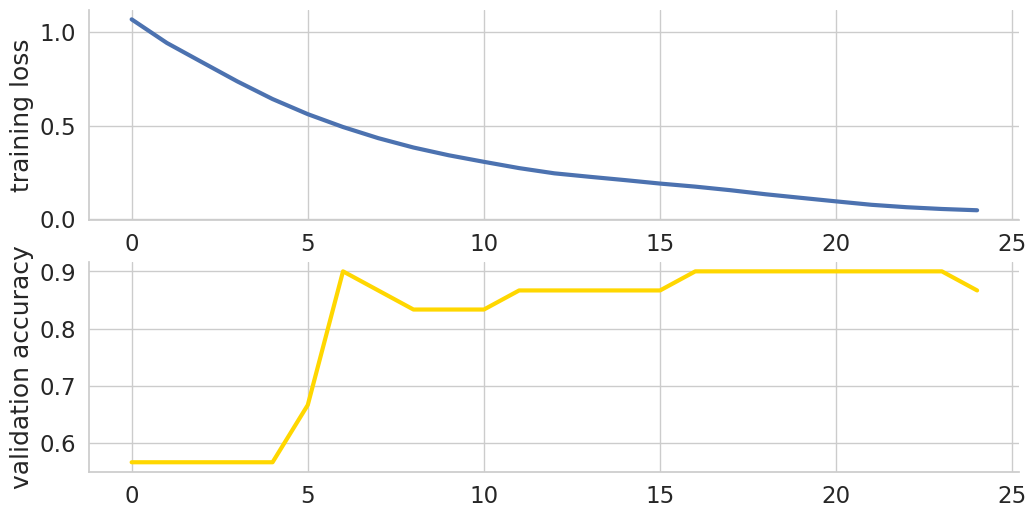

In [8]:
# Plot training loss and validation accuracy throughout the training epochs

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [9]:
with torch.no_grad():
    
    # Pass the testing feature data (30 samples) to the network to produce model predictions
    y_pred_test = model(testing_inputs) 
    
    # Use the same technique as above to commpute the testing classification accuracy
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')

Testing Accuracy: 89.99999761581421%
